<a href="https://colab.research.google.com/github/shay-dan/DS_workshop_OpenUIL/blob/main/Weight_estimation_with_bounding_box.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#8.Weight estimation with bounding box

##8.1  Detectron2

### preprocess

import drive, where saved all image outputs from Detectron, Yolo and Sam models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Organize all result images from models in pairs. Each pair will have top and side image of the same plate

In [ ]:
import os
def get_pairs(path = '/content/drive/MyDrive/split_and_augment/test'):
  side = []
  top = []
  side_sorted = []
  top_sorted = []
  for filename in os.listdir(path):
    if filename.split(".json")[0] == 'Test':
      continue
    tmp  = filename.split(".JPG")[0]
    tmp = tmp.split("(")[0]
    if tmp[-1] == 'S':
      side.append(filename)
    elif tmp[-1] == 'T':
      top.append(filename)
    else:
      print(filename, " is not top or side image")
  side = sorted(side)
  top = sorted(top)
  for s in side:
    for t in top:
      tmps1 = s.split("S")[0]
      tmps2 = s.split("S")[1]
      tmpt1 = t.split("T")[0]
      tmpt2 = t.split("T")[1]
      if tmps1 == tmpt1:
        if tmps2 ==tmpt2:
          side_sorted.append(path + '/' + s)
          top_sorted.append(path + '/' + t)

  pairs = list(zip(side_sorted, top_sorted))
  return pairs

In [ ]:
pairs = get_pairs("/content/drive/MyDrive/test_results_aug")
pairs

output_objects (1).gsheet  is not top or side image
output_objects.csv  is not top or side image
output_objects2.csv  is not top or side image
output_objects.gsheet  is not top or side image
output_objects_detectron2.csv  is not top or side image


[('/content/drive/MyDrive/test_results_aug/apple010S(1)_result.jpg',
  '/content/drive/MyDrive/test_results_aug/apple010T(1)_result.jpg'),
 ('/content/drive/MyDrive/test_results_aug/apple014S(6)-detectron2-result.jpg',
  '/content/drive/MyDrive/test_results_aug/apple014T(6)-detectron2-result.jpg'),
 ('/content/drive/MyDrive/test_results_aug/apple014S(6)_result.jpg',
  '/content/drive/MyDrive/test_results_aug/apple014T(6)_result.jpg'),
 ('/content/drive/MyDrive/test_results_aug/apple016S(12)_result.jpg',
  '/content/drive/MyDrive/test_results_aug/apple016T(12)_result.jpg'),
 ('/content/drive/MyDrive/test_results_aug/apple017S(26)_result.jpg',
  '/content/drive/MyDrive/test_results_aug/apple017T(26)_result.jpg'),
 ('/content/drive/MyDrive/test_results_aug/apple018S(2)_result.jpg',
  '/content/drive/MyDrive/test_results_aug/apple018T(2)_result.jpg'),
 ('/content/drive/MyDrive/test_results_aug/banana004S(1)_result.jpg',
  '/content/drive/MyDrive/test_results_aug/banana004T(1)_result.jpg'),

In [ ]:
# check if each pair has 2 images, and there are 100 pairs
def pairs_test(pairs):
  correct = 1
  for pair in pairs:
    if len(pair) != 2:
      print("error in: ",pair)
      correct = 0
  if len(pairs) != 130:
    print("incorrect number of pairs")
    correct = 0
  if correct:
    print("pairs organized correctly")

# test
pairs_test(pairs)

pairs organized correctly


In [ ]:
# import csv where the image result are
path_to_csv = "/content/drive/MyDrive/test_results_aug/output_objects.csv"

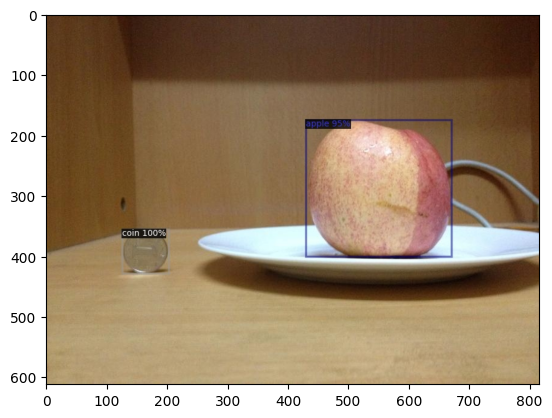

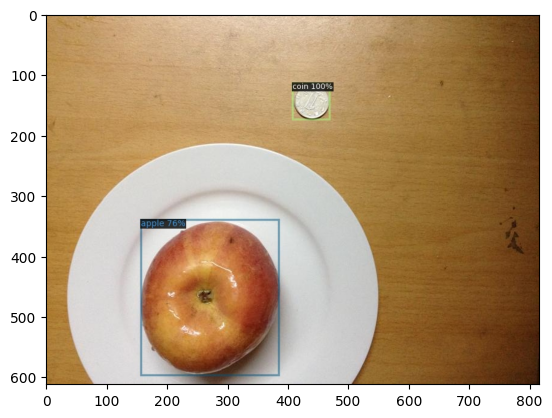

In [ ]:
import cv2
import matplotlib.pyplot as plt

def display_img(path_to_img):
  img_t = cv2.imread(path_to_img)[:,:,::-1]
  plt.imshow(img_t)
  plt.show()

display_img(pairs[0][0])
display_img(pairs[0][1])

### get bbox/cls lists

In [ ]:
import os
import csv

def extract_info_from_path(file_path):
    # Get the filename from the path
    file_name = os.path.basename(file_path)
    # Split the filename using "." and take the first part
    file_name_without_extension = file_name.split(".")[0]
    # Extract the desired format using parentheses
    parts = file_name_without_extension.split("(")
    class_name = parts[0]
    number = parts[1].split(")")[0]
    # Construct the desired format
    result = f"{class_name}({number})"
    return result

def get_prediction_info(image_name,csv_file):
    image_name = extract_info_from_path(image_name)
    try:
        with open(csv_file, 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                if extract_info_from_path(row['image']) == image_name:
                    return row['pred_class'], row['pred_bbox']
    except FileNotFoundError:
        print(f"Error: File '{csv_file}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
print(extract_info_from_path(pairs
[50][0]))
# Example usage
print(get_prediction_info(pairs[50][0],path_to_csv))

grape002S(10)
("['coin', 'grape']", "Boxes(tensor([[ 98.6163, 303.6489, 166.9972, 366.9944],\n        [366.9069, 189.5159, 674.4800, 356.1041]], device='cuda:0'))")


In [ ]:
# organize all bbox in a list
def get_bbox_list(input):
  st = input
  bbox_list = []
  first_ch,last_ch,idk = 0,0,0
  for ch in st:
    if ch == '[':
      first_ch = idk
    if ch == ']':
      last_ch = idk+1
      bbox_list.append(input[first_ch:last_ch])
      first_ch = 0
      last_ch = 0
    idk += 1
  bbox_list  = bbox_list[:-1]
  return bbox_list

# change from [x1,y1,x2,y2] format to coco format [x1,y1,width,height]
def change_bbox_to_coco(bbox):
  coco_bbox = []
  x1 = bbox[0]
  y1 = bbox[1]
  x2 = bbox[2]
  y2 = bbox[3]
  width = x2-x1
  height = y2-y1
  return [x1,y1,width,height]

# Example usage
cls,bbox = get_prediction_info(pairs[50][0],path_to_csv)
bbox_list = get_bbox_list(bbox)
print(bbox_list)
# Example usage
print([10,50,60,80])

['[ 98.6163, 303.6489, 166.9972, 366.9944]', '[366.9069, 189.5159, 674.4800, 356.1041]']
[10, 50, 60, 80]


In [ ]:
import ast
import re

def get_bbox(image_name, csv_file):
    _, bbox = get_prediction_info(image_name, csv_file)
    # Extract the bounding box information using regular expressions and string manipulation
    bbox_matches = re.findall(r'\[\[(.*?)\],\s*\[(.*?)\]\]', bbox)
    bbox_list = get_bbox_list(bbox)
    final_bboxes = []
    for bbox in bbox_list:
      bbox = ast.literal_eval(bbox)
      final_bboxes.append(change_bbox_to_coco(bbox))
    return final_bboxes

# get only class of an image from csv
def get_cls(image_name,csv_file):
    image_name = extract_info_from_path(image_name)
    # i = 0
    try:
        with open(csv_file, 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                if extract_info_from_path(row['image']) == image_name:
                  # Convert the string to an actual list
                    actual_list = ast.literal_eval(row['pred_class'])
                    return actual_list
    except FileNotFoundError:
        print(f"Error: File '{csv_file}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

Let's see an example to it

In [ ]:
print(pairs[15][0],"\n",get_cls(pairs[15][0],path_to_csv),"\n",get_bbox(pairs[15][0],path_to_csv),"\n")
print(pairs[58][0],"\n",get_cls(pairs[58][0],path_to_csv),"\n",get_bbox(pairs[58][0],path_to_csv),"\n")
print(pairs[2][1],"\n",get_cls(pairs[2][1],path_to_csv),"\n",get_bbox(pairs[2][1],path_to_csv))

/content/drive/MyDrive/test_results_aug/bread003S(3)-detectron2-result.jpg 
 ['coin', 'bread'] 
 [[694.2759, 368.3257, 85.75819999999999, 79.95240000000001], [36.4934, 362.602, 497.03310000000005, 83.56970000000001]] 

/content/drive/MyDrive/test_results_aug/lemon003S(6)_result.jpg 
 ['coin', 'lemon'] 
 [[178.3135, 274.681, 66.439, 59.25659999999999], [476.1562, 188.4594, 161.50710000000004, 137.75360000000003]] 

/content/drive/MyDrive/test_results_aug/apple014T(6)_result.jpg 
 ['coin', 'apple'] 
 [[63.6538, 124.0086, 62.22010000000001, 61.0557], [301.8873, 245.0895, 223.75850000000003, 211.25990000000002]]


In [ ]:
path_to_img = pairs[0][0]
bbox = get_bbox(path_to_img,path_to_csv)
cls = get_cls(path_to_img,path_to_csv)

print(f"The bbox of the object is: {bbox[1]}")
print(f"The bbox of the coin is: {bbox[0]}")
print(f"The class of the object is: {cls[-1]}")

The bbox of the object is: [430.3214, 175.2003, 240.47899999999998, 225.80999999999997]
The bbox of the coin is: [125.6813, 356.2892, 77.23160000000001, 72.49310000000003]
The class of the object is: apple


### find edge cases

Our input data is an output from prediction of another model, therefore we've got some mistakes in it. We are going to find all the pairs that has different number of objects in each image.

96


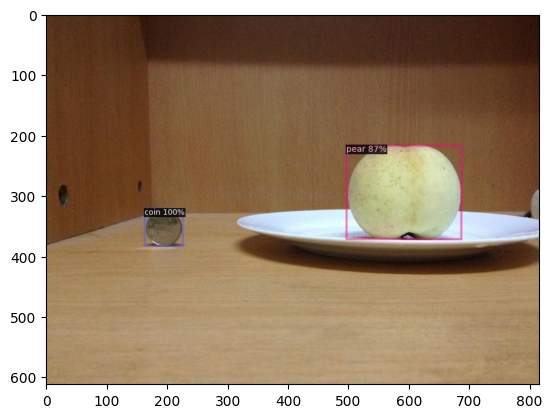

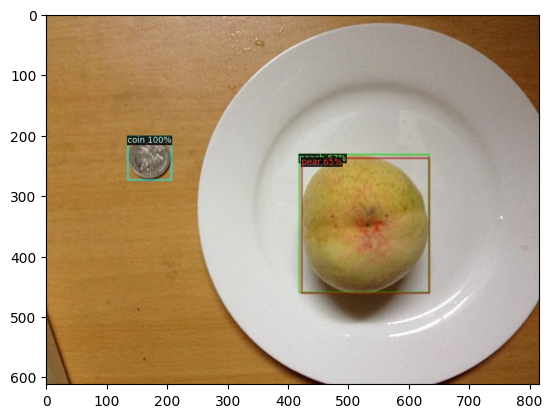

40


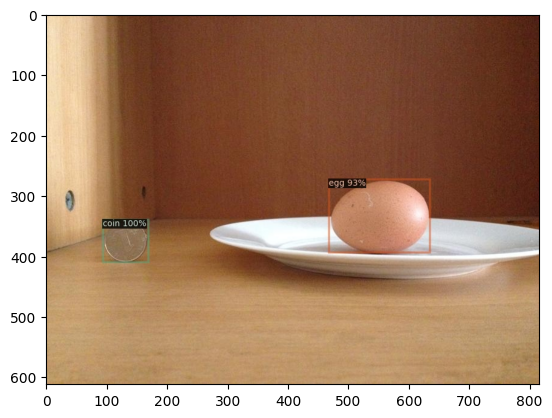

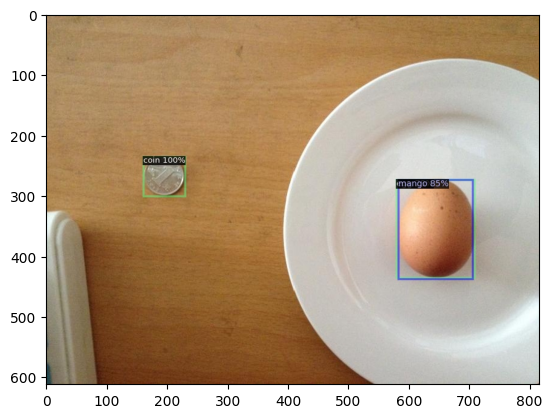

78


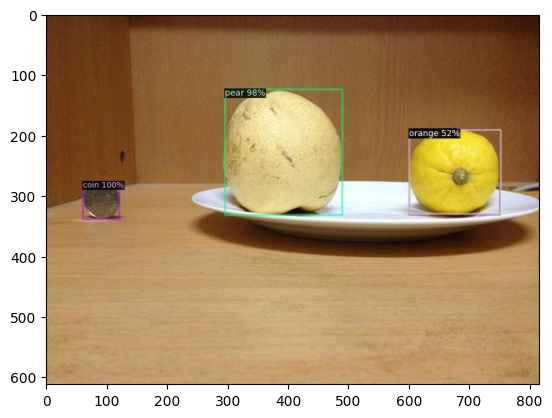

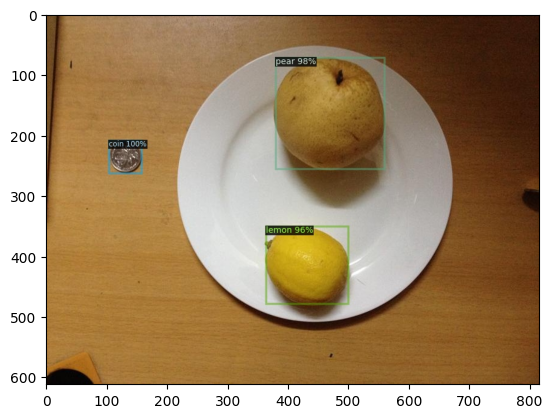

79


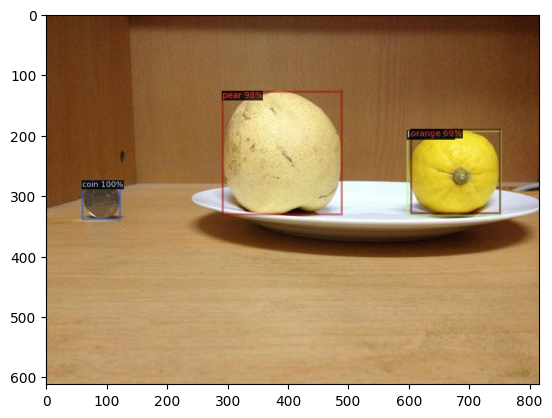

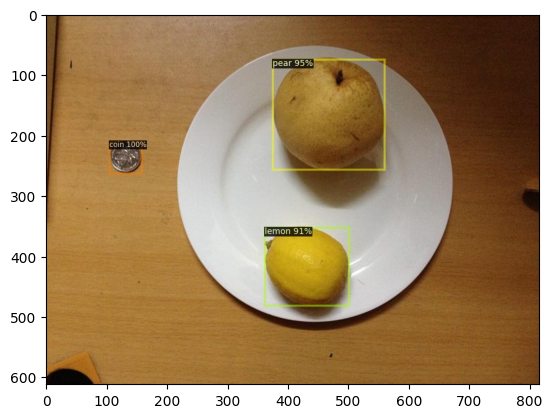

20


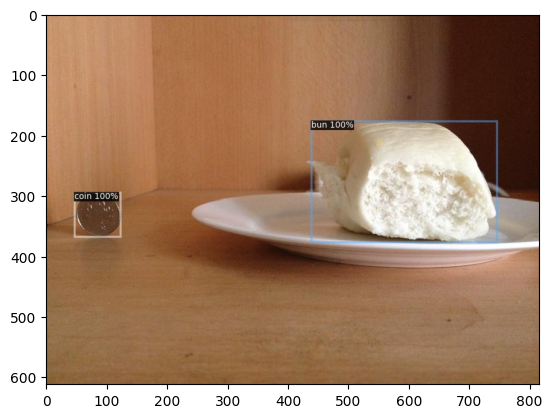

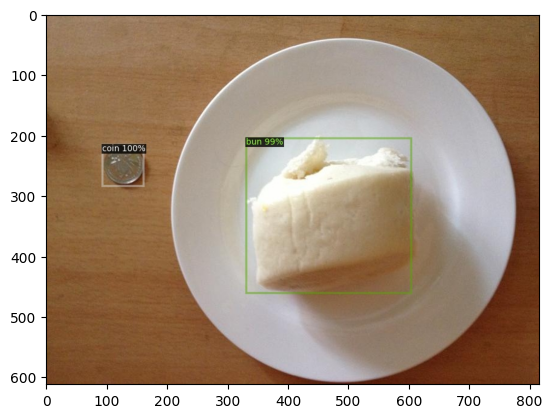

21


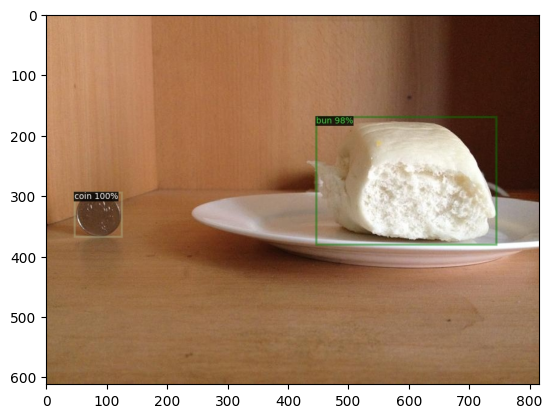

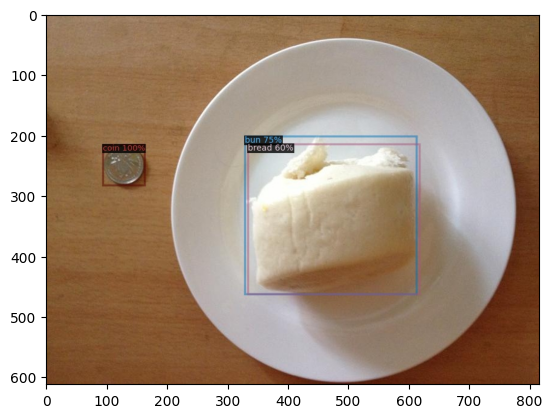

116


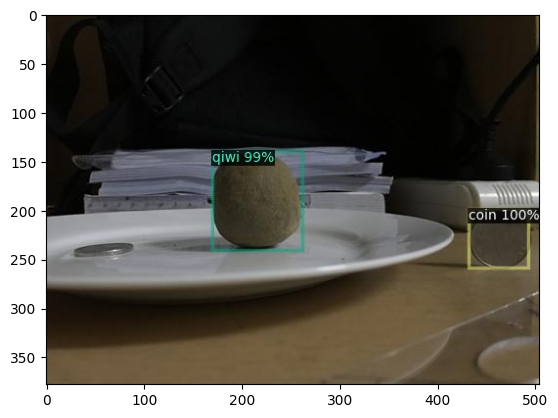

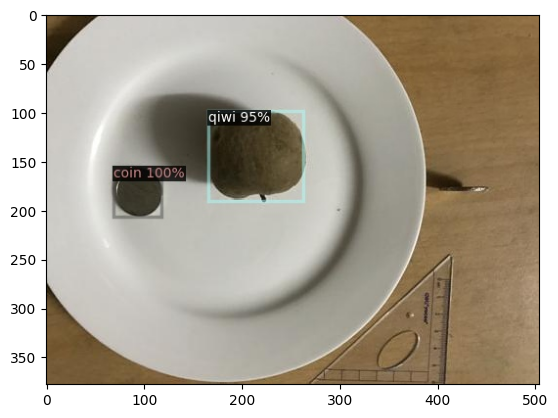

117


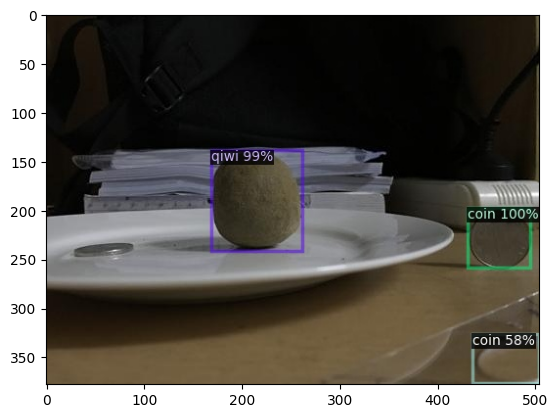

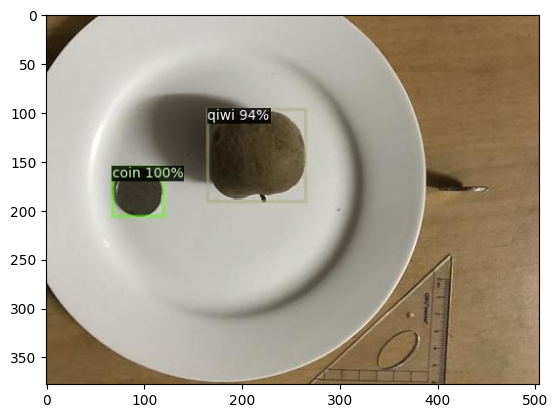

In [ ]:
def top_and_side_num_of_objs_not_equal(csv_file):
  bad_images_result = []
  for i in range(len(pairs)):
    if len(get_cls(pairs[i][0],csv_file)) != len(get_cls(pairs[i][1],csv_file)):
      bad_images_result.append(i)
  return bad_images_result

def top_and_side_cls_is_different(csv_file):
  bad_images_result = []
  for i in range(len(pairs)):
    top_set = set(get_cls(pairs[i][0],csv_file))
    side_set = set(get_cls(pairs[i][1],csv_file))
    if top_set != side_set:
      bad_images_result.append(i)
  return bad_images_result

for i in set(top_and_side_cls_is_different(path_to_csv) +
             top_and_side_num_of_objs_not_equal(path_to_csv)):
             print(i)
             display_img(pairs[i][0])
             display_img(pairs[i][1])

As we can see, all the pairs that has different amount of objects in each image has an issue that one image from the pair has all the objects that the other have, and al least one more.
Therefore we will calculate the volume weight and nutritions value only for object that was found in both images in a pair.

### calc volume

In [ ]:
# constants
coin_radius_in_mm = 12.5
coin_diameter_in_mm = 25

In [ ]:
# find relevant bbox from bbox list for a given object
def get_bbox_per_obj(clses,bboxes,obj):
  for cls,bbox in zip(clses,bboxes):
    if cls == obj:
      return bbox

def get_relevant_objs(pair):
  cls_list_s = get_cls(pair[0],path_to_csv)
  cls_list_t = get_cls(pair[1],path_to_csv)
  objs = []
  # check if both side and top image has same amount of objects
  if len(cls_list_s) < len(cls_list_t):
    for obj in cls_list_s:
      objs.append(obj)
  else:
    for obj in cls_list_t:
      objs.append(obj)
  return objs

# return [cls,bbox_s,bbox_t]
def organize_cls_and_bboxes(pair):
  objs = get_relevant_objs(pair)
  obj_bboxes = []
  bbox_list_s = get_bbox(pair[0],path_to_csv)
  bbox_list_t = get_bbox(pair[1],path_to_csv)
  for obj in objs:
    bbox_s = get_bbox_per_obj(objs,bbox_list_s,obj)
    bbox_t = get_bbox_per_obj(objs,bbox_list_t,obj)
    obj_bboxes.append([obj,bbox_s,bbox_t])
  return obj_bboxes

def calc_ratio(coin_bbox):
  coin_height_in_pixel = coin_bbox[-1]
  return coin_diameter_in_mm / coin_height_in_pixel

Let's see exmaple to for better understanding for the following code above

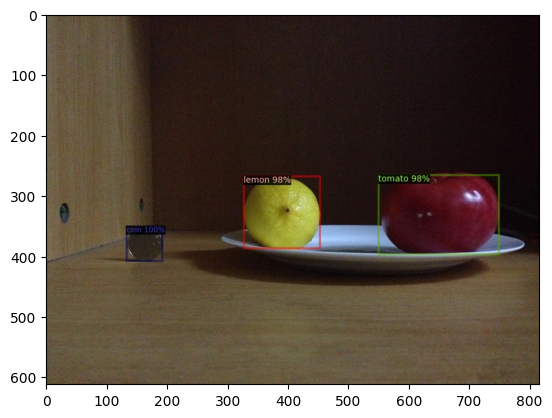

0.43297240753441246
[['coin', [131.9711, 350.7643, 62.73909999999998, 57.74040000000002], [136.1848, 156.3311, 58.7225, 56.1113]], ['tomato', [323.291, 268.7778, 133.9588, 122.344], [394.6312, 65.048, 193.29789999999997, 200.0596]], ['lemon', [549.5911, 264.2004, 199.53730000000007, 136.16269999999997], [374.6633, 372.3821, 165.40249999999997, 134.0066]]]
['coin', [131.9711, 350.7643, 62.73909999999998, 57.74040000000002], [136.1848, 156.3311, 58.7225, 56.1113]]
['tomato', [323.291, 268.7778, 133.9588, 122.344], [394.6312, 65.048, 193.29789999999997, 200.0596]]
['lemon', [549.5911, 264.2004, 199.53730000000007, 136.16269999999997], [374.6633, 372.3821, 165.40249999999997, 134.0066]]


In [ ]:
pair = pairs[76]
display_img(pair[0])
coin_bbox = organize_cls_and_bboxes(pair)[0][1]
ratio = calc_ratio(coin_bbox)

tomato = organize_cls_and_bboxes(pair)[1]
lemon = organize_cls_and_bboxes(pair)[2]
coin = organize_cls_and_bboxes(pair)[0]

print(ratio)
print(organize_cls_and_bboxes(pair))
print(coin)
print(tomato)
print(lemon)

In [ ]:
# relevant only for S (side) images
def get_height(bbox,ratio):
  height_in_pixel = bbox[-1]
  return height_in_pixel * ratio

# relevant only for T (top) images
def get_radius(bbox,ratio):
  radius_in_pixel = bbox[-1] / 2
  return radius_in_pixel * ratio
'''
define for all our objects in the dataset the relevant volume formula
for volume calculation and the avg_density for weight calculation
'''

# obj = label: [volume formula, avg_density]
objects = {"apple": ["ball",0.79], "banana": ["cylinder",0.92],"bread":["box",0.19],
           "bun": ["box",0.34],"doughnut":["cylinder",0.31],
           "egg":["cylinder",1.24],"fired_dough_twist":["cylinder",0.63],
           "grape":["box",0.96],"lemon": ["ball",0.96],
           "litchi": ["ball",1.00],"mango":["cylinder",0.92],
           "mooncake":["cylinder",1.04],"orange":["ball",0.95],
           "pear":["ball",0.95],"peach": ["ball",1.02],"plum": ["ball",1.01],
           "qiwi":["cylinder",0.98],"sachima":["box",0.22],"tomato":["cylinder",0.98],"mix":["ball",0.8]}
            # need to delete mix from here
import math
# only circle
def get_circle_area(bbox,ratio):
  return get_radius(bbox,ratio)**2 * math.pi

# only box
def get_box_area(bbox,ratio):
  return (get_radius(bbox,ratio)*2)**2

def get_volume(bbox_s,bbox_t,ratio_s,ratio_t,label):
  if objects[label][0] == "ball":
    return get_radius(bbox_t,ratio_t)**3 * math.pi * (4/3)
  if objects[label][0] == "cylinder":
    return get_height(bbox_s,ratio_s) * get_circle_area(bbox_t,ratio_t)
  if objects[label][0] == "box":
    return get_box_area(bbox_t,ratio_t) * get_height(bbox_s,ratio_s)
  if objects[label][0] == "ellipsoid":
    return 0

now we can use the volume functions and calc height, radius, area and volume.
let's see an example

In [ ]:
coin_bbox = organize_cls_and_bboxes(pair)[0][1]
ratio_s = calc_ratio(coin_bbox)

coin_bbox = organize_cls_and_bboxes(pair)[0][2]
ratio_t = calc_ratio(coin_bbox)

print("tomato height:\t",get_height(tomato[1],ratio_s),"mm")
print("lemon height:\t",get_height(lemon[1],ratio_s),"mm")
print("tomato radius:\t",get_radius(tomato[2],ratio_t),"mm")
print("lemon radius:\t",get_radius(lemon[2],ratio_t),"mm")

tomato_volume = get_volume(tomato[1],tomato[2],ratio_s,ratio_t,tomato[0])
lemon_volume = get_volume(lemon[1],lemon[2],ratio_s,ratio_t,lemon[0])

print("tomato volume:\t",tomato_volume, "mm^3")
print("lemon volume:\t",lemon_volume, "mm^3")

tomato height:	 52.97157622739016 mm
lemon height:	 58.95469203538593 mm
tomato radius:	 44.5675826437812 mm
lemon radius:	 29.852854950785314 mm
tomato volume:	 330545.2538551694 mm^3
lemon volume:	 111441.31336936362 mm^3


In [ ]:
def get_volume_from_for_all_objs_in_plate(pair):
  obj_and_bboxes_list = organize_cls_and_bboxes(pair)
  # calc pixel per mm ratio based on the yuan coin dimensions
  coin_bbox = []
  for obj in obj_and_bboxes_list:
    if obj[0] == "coin":
      # bbox_t
      coin_bbox.append(obj[1])
      # bbox_s
      coin_bbox.append(obj[2])
  ratio_s = calc_ratio(coin_bbox[0])
  ratio_t = calc_ratio(coin_bbox[1])
  # Remove sublists containing 'coin'
  obj_and_bboxes_list = [sublist for sublist in obj_and_bboxes_list if sublist[0] != 'coin']
  volume = []
  for cls,bbox_s,bbox_t in obj_and_bboxes_list:
    volume.append([cls,get_volume(bbox_s,bbox_t,ratio_s,ratio_t,cls)])
  return volume

final exmaple for volume calculation

In [ ]:
get_volume_from_for_all_objs_in_plate(pair)

[['tomato', 330545.2538551694], ['lemon', 111441.31336936362]]

now all we need is to use the density for the object and the volume to get it's weight

In [ ]:
def get_weight(pair):
  volume_list = get_volume_from_for_all_objs_in_plate(pair)
  weight_list = []
  for cls,volume in volume_list:
    weight = volume * objects[cls][1]
    weight_list.append([cls,weight])
  return weight_list

In [ ]:
print(get_weight(pair))
print(get_weight(pairs[10]))
print(get_weight(pairs[55]))
print(get_weight(pairs[70]))

[['tomato', 323934.348778066], ['lemon', 106983.66083458907]]
[['banana', 857002.1463255316]]
[['lemon', 120108.29324599585]]
[['mango', 233719.8353366466]]


We can see that out result and not close to the currect volume or weight. We will use the real volume and weight to add constant numbers to our volume calculation, and then we will be able to check our weight calculation accuracy.

### get real volume and weight

In [ ]:
import pandas as pd
!git clone https://github.com/Liang-yc/ECUSTFD-resized-.git

w_v_df = pd.read_excel(
    "/content/ECUSTFD-resized-/density.xls",
    sheet_name=None,
)
w_v_df = pd.concat(w_v_df.values(), axis=0)
w_v_df = w_v_df.reset_index(drop=True)
w_v_df

Cloning into 'ECUSTFD-resized-'...
remote: Enumerating objects: 9232, done.
remote: Total 9232 (delta 0), reused 0 (delta 0), pack-reused 9232
Receiving objects: 100% (9232/9232), 124.79 MiB | 23.68 MiB/s, done.
Resolving deltas: 100% (6129/6129), done.
Updating files: 100% (5962/5962), done.


id     type  volume(mm^3)  weight(g)
0      apple001    apple           310      244.5
1      apple002    apple           290      232.5
2      apple003    apple           280      219.0
3      apple004    apple           300      234.0
4      apple005    apple           280      212.5
..          ...      ...           ...        ...
169  sachima005  sachima           150       32.7
170   tomato001   tomato           210      214.5
171   tomato002   tomato           190      154.2
172   tomato003   tomato           180      186.4
173   tomato004   tomato           160      173.4

[174 rows x 4 columns]

In [ ]:
def extract_filename(path):
    # Get the base filename without extension
    filename = os.path.splitext(os.path.basename(path))[0]
    # Find the index of the first occurrence of 'S' or 'T' in the filename
    stop_index = max(filename.find('S'), filename.find('T')) if 'S' in filename or 'T' in filename else -1
    # If 'S' or 'T' is found, cut the filename up to that point
    if stop_index != -1:
        filename = filename[:stop_index]
    return filename

In [ ]:
print(pairs[59][0],"\t",extract_filename(pairs[59][0]))

/content/drive/MyDrive/test_results_aug/litchi002S(6)_result.jpg 	 litchi002


In [ ]:
def get_real_w_v(obj):
  obj = extract_filename(obj)
  return w_v_df.loc[w_v_df['id'].isin([obj])]

In [ ]:
get_real_w_v("mix005")

id   type  volume(mm^3)  weight(g)
101  mix005  mango           185      192.3
102  mix005   qiwi           160      152.2

In [ ]:
def get_real_v(obj):
    obj = extract_filename(obj)
    if obj[0:3] == "mix":
      element1 = [get_real_w_v(obj).iat[0, 1],get_real_w_v(obj).iat[0, 2]]
      element2 = [get_real_w_v(obj).iat[1, 1],get_real_w_v(obj).iat[1, 2]]
      return [element1,element2]
    return [get_real_w_v(obj).iat[0, 1],get_real_w_v(obj).iat[0, 2]]

def get_real_w(obj):
    obj = extract_filename(obj)
    if obj[0:3] == "mix":
      element1 = [get_real_w_v(obj).iat[0, 1],get_real_w_v(obj).iat[0, 3]]
      element2 = [get_real_w_v(obj).iat[1, 1],get_real_w_v(obj).iat[1, 3]]
      return [element1,element2]
    return [get_real_w_v(obj).iat[0, 1],get_real_w_v(obj).iat[0, 3]]

In [ ]:
obj = "mix005"
print(f" The {obj} real volume is:",get_real_v(obj))
print(f" The {obj} real weight is:",get_real_w(obj))
obj = "egg005"
print(f" The {obj} real volume is:",get_real_v(obj))
print(f" The {obj} real weight is:",get_real_w(obj))

 The mix005 real volume is: [['mango', 185], ['qiwi', 160]]
 The mix005 real weight is: [['mango', 192.3], ['qiwi', 152.2]]
 The egg005 real volume is: ['egg', 50]
 The egg005 real weight is: ['egg', 59.5]


### increase weight estimation accuracy

after we find the true value for each plate we can increase our calculation accuracy. we will initilize constant number for each volume formula: ball, box, cylinder

In [ ]:
ball_obj_example = pairs[0]
box_obj_example = pairs[12]
cylinder_obj_example = pairs[65]

print(ball_obj_example)
print(box_obj_example)
print(cylinder_obj_example)

print("predict apple volume\t",get_volume_from_for_all_objs_in_plate(ball_obj_example)[0][1],"mm^3")
print("predict bread volume\t",get_volume_from_for_all_objs_in_plate(box_obj_example)[0][1],"mm^3")
print("predict mango volume\t",get_volume_from_for_all_objs_in_plate(cylinder_obj_example)[0][1],"mm^3")

print("real apple volume\t",get_real_v(ball_obj_example[0])[1],"mm^3")
print("real bread volume\t",get_real_v(box_obj_example[0])[1],"mm^3")
print("real mango volume\t",get_real_v(cylinder_obj_example[0])[1],"mm^3")

('/content/drive/MyDrive/test_results_aug/apple010S(1)_result.jpg', '/content/drive/MyDrive/test_results_aug/apple010T(1)_result.jpg')
('/content/drive/MyDrive/test_results_aug/bread001S(4)_result.jpg', '/content/drive/MyDrive/test_results_aug/bread001T(4)_result.jpg')
('/content/drive/MyDrive/test_results_aug/mango004S(3)-detectron2-result.jpg', '/content/drive/MyDrive/test_results_aug/mango004T(3)-detectron2-result.jpg')
predict apple volume	 614553.6177791585 mm^3
predict bread volume	 647010.7953227188 mm^3
predict mango volume	 107994.76774553975 mm^3
real apple volume	 330 mm^3
real bread volume	 140 mm^3
real mango volume	 60 mm^3


In [ ]:
ball_volume_constant = 330/614553.6177791585
box_volume_constant = 140/647010.7953227188
cylinder_volume_constant = 60/107994.76774553975

In [ ]:
def get_volume(bbox_s,bbox_t,ratio_s,ratio_t,label):
  if objects[label][0] == "ball":
    return get_radius(bbox_t,ratio_t)**3 * math.pi * (4/3) * ball_volume_constant
  if objects[label][0] == "cylinder":
    return get_height(bbox_s,ratio_s) * get_circle_area(bbox_t,ratio_t) * cylinder_volume_constant
  if objects[label][0] == "box":
    return get_box_area(bbox_t,ratio_t) * get_height(bbox_s,ratio_s) * box_volume_constant
  if objects[label][0] == "ellipsoid":
    return 0

In [ ]:
print("predict apple volume\t",get_volume_from_for_all_objs_in_plate(ball_obj_example)[0][1],"mm^3")
print("predict bread volume\t",get_volume_from_for_all_objs_in_plate(box_obj_example)[0][1],"mm^3")
print("predict mango volume\t",get_volume_from_for_all_objs_in_plate(cylinder_obj_example)[0][1],"mm^3")

print("real apple volume\t",get_real_v(ball_obj_example[0])[1],"mm^3")
print("real bread volume\t",get_real_v(box_obj_example[0])[1],"mm^3")
print("real mango volume\t",get_real_v(cylinder_obj_example[0])[1],"mm^3")

predict apple volume	 330.0 mm^3
predict bread volume	 140.0 mm^3
predict mango volume	 59.99999999999999 mm^3
real apple volume	 330 mm^3
real bread volume	 140 mm^3
real mango volume	 60 mm^3


### accuracy test

let's check more deeply our accuracy

In [ ]:
def calc_error(predict,real):
  guess = []
  accurate = []
  for _,num in predict:
    guess.append(num)
  for _,num in real:
    accurate.append(num)
  error = []
  for estimate,correct in zip(guess,accurate):
    # calculate the error in percentage
    error_percentage = abs((estimate - correct) / correct) * 100
    error.append(error_percentage)
  # Calculate the mean error
  error = sum(error) / len(error)
  return error

In [ ]:
import random
def check_accuracy():
  rnd = random.randint(0, 100)
  pair = pairs[rnd]
  img_s = pair[0]
  img_t = pair[1]

  pred_v = get_volume_from_for_all_objs_in_plate(pair)
  pred_w = get_weight(pair)
  real_v = get_real_v(img_s)
  real_w = get_real_w(img_s)

  # adapt for only 1 obj in image
  if len(pred_v) == 1:
    real_v = [real_v]
    real_w = [real_w]

  pred_v = sorted(pred_v, key=lambda x: x[0])
  pred_w = sorted(pred_w, key=lambda x: x[0])
  real_v = sorted(real_v, key=lambda x: x[0])
  real_w = sorted(real_w, key=lambda x: x[0])

  print("-------images-------")
  print(img_s)
  print(img_t,"\n")

  for p_v,p_w,v,w in zip (pred_v,pred_w,real_v,real_w):
    print("-------predict-------")
    print(f"{p_v[0]} predict volume is {p_v[1]} mm^3")
    print(f"{p_w[0]} predict weight is {p_w[1]} g\n")
    print("-------real-------:")
    print(f"{v[0]} real volume is {v[1]} mm^3")
    print(f"{w[0]} real weight is {w[1]} g\n")

  print("-------error-------")
  print(f"volume error is {calc_error(pred_v,real_v)} %")
  print(f"weight error is {calc_error(pred_w,real_w)} %")
  print()

In [ ]:
check_accuracy()
check_accuracy()

-------images-------
/content/drive/MyDrive/test_results_aug/mix009S(1)_result.jpg
/content/drive/MyDrive/test_results_aug/mix009T(1)_result.jpg 

-------predict-------
lemon predict volume is 53.933694274824475 mm^3
lemon predict weight is 51.7763465038315 g

-------real-------:
lemon real volume is 100 mm^3
lemon real weight is 94.2 g

-------predict-------
orange predict volume is 163.2735015303608 mm^3
orange predict weight is 155.10982645384274 g

-------real-------:
orange real volume is 270 mm^3
orange real weight is 232.5 g

-------error-------
volume error is 42.79731924585428 %
weight error is 39.16091086434078 %

-------images-------
/content/drive/MyDrive/test_results_aug/bread003S(1)_result.jpg
/content/drive/MyDrive/test_results_aug/bread003T(1)_result.jpg 

-------predict-------
bread predict volume is 90.0142957413146 mm^3
bread predict weight is 17.102716190849772 g

-------real-------:
bread real volume is 160 mm^3
bread real weight is 26.0 g

-------error-------
volu

now let's check the accuracy for all the data test

In [ ]:
def get_accuracy_in_one_pair(pair_index):

  pair = pairs[pair_index]
  img_s = pair[0]
  img_t = pair[1]

  pred_w = get_weight(pair)
  real_w = get_real_w(img_s)

  # mix or one object
  flag = "mix"
  # adapt for only 1 obj in image
  if len(pred_w) == 1:
    real_w = [real_w]
    flag = "one object"

  pred_w = sorted(pred_w, key=lambda x: x[0])
  real_w = sorted(real_w, key=lambda x: x[0])
  if flag == "one object":
    return [pred_w[0][0],calc_error(pred_w,real_w)]
  return ["mix",calc_error(pred_w,real_w)]


def get_accuracy_in_all_dataset():
  error_list = []
  for i in range(len(pairs)):
    error_list.append(get_accuracy_in_one_pair(i))

  # convert to dictationary
  result_dict = {}
  for item in error_list:
    key, value = item[0], item[1]

    if key in result_dict:
        result_dict[key].append(value)
    else:
        result_dict[key] = [value]

  # save only the mean error per class
  sum_of_all_values = 0
  for key, values in result_dict.items():
    result_dict[key] = sum(values) / len(values)
    sum_of_all_values += sum(values)

  # Calculate mean error for all values
  # Add "error of the data test" to the result_dict
  result_dict["error of the data test"] = sum_of_all_values / len(pairs)

  return result_dict

In [ ]:
get_accuracy_in_all_dataset()

{'apple': 25.82989321985954,
 'banana': 119.69227390924304,
 'bread': 14.907502387009496,
 'bun': 46.182285305348984,
 'doughnut': 21.64983217449857,
 'egg': 21.1749890095517,
 'fired_dough_twist': 152.59023162347077,
 'grape': 23.95572971405469,
 'lemon': 28.375077543556397,
 'litchi': 13.686685355449045,
 'mango': 15.636979744534754,
 'mix': 32.042397304261215,
 'mooncake': 23.379160413705176,
 'orange': 21.933625575072114,
 'peach': 31.69999037481226,
 'pear': 34.091893047997786,
 'plum': 23.501103292545377,
 'qiwi': 19.624375332848242,
 'sachima': 72.06386812317865,
 'tomato': 19.321080252254205,
 'error of the data test': 38.84742222288313}

In [ ]:
def error_summary():
  input_dict = get_accuracy_in_all_dataset()
  # Find key with highest value
  max_key = max(input_dict, key=input_dict.get)
  max_value = input_dict[max_key]

  # Find key with lowest value
  min_key = min(input_dict, key=input_dict.get)
  min_value = input_dict[min_key]

  # Print results
  print("Highest error:", max_key)
  print("Value:", max_value,"%")
  print("\nLowest error:", min_key)
  print("Value:", min_value,"%")
  print("\nMean error:")
  print("Value", ":", list(input_dict.values())[-1],"%")

error_summary()

Highest error: fired_dough_twist
Value: 152.59023162347077 %

Lowest error: litchi
Value: 13.686685355449045 %

Mean error:
Value : 38.84742222288313 %


As we see, The precision is really bad.
We can do several things to improve the accuracy, such as learn the constant number for the volume calculation, get more accurate bounding box from the model that gave us the input, or try to use mask or segmentation instead of bounding box to incearse the accuracy.

##8.2  Yolo

### preprocess

In [ ]:
path_to_csv = "/content/drive/MyDrive/test_imgs_res/output_objects_yolo.csv"
path_to_imgs_dir = "/content/drive/MyDrive/test_imgs_res"

In [ ]:
pairs = get_pairs(path_to_imgs_dir)
pairs

output_objects_yolo.csv  is not top or side image


[('/content/drive/MyDrive/test_imgs_res/apple010S(1).JPG-YOLOv8-result.JPG',
  '/content/drive/MyDrive/test_imgs_res/apple010T(1).JPG-YOLOv8-result.JPG'),
 ('/content/drive/MyDrive/test_imgs_res/apple014S(6).JPG-YOLOv8-result.JPG',
  '/content/drive/MyDrive/test_imgs_res/apple014T(6).JPG-YOLOv8-result.JPG'),
 ('/content/drive/MyDrive/test_imgs_res/apple016S(12).JPG-YOLOv8-result.JPG',
  '/content/drive/MyDrive/test_imgs_res/apple016T(12).JPG-YOLOv8-result.JPG'),
 ('/content/drive/MyDrive/test_imgs_res/apple017S(26).JPG-YOLOv8-result.JPG',
  '/content/drive/MyDrive/test_imgs_res/apple017T(26).JPG-YOLOv8-result.JPG'),
 ('/content/drive/MyDrive/test_imgs_res/apple018S(2).JPG-YOLOv8-result.JPG',
  '/content/drive/MyDrive/test_imgs_res/apple018T(2).JPG-YOLOv8-result.JPG'),
 ('/content/drive/MyDrive/test_imgs_res/banana004S(1).JPG-YOLOv8-result.JPG',
  '/content/drive/MyDrive/test_imgs_res/banana004T(1).JPG-YOLOv8-result.JPG'),
 ('/content/drive/MyDrive/test_imgs_res/banana007S(1).JPG-YOLOv8

In [ ]:
# check if each pair has 2 images, and there are 100 pairs
def pairs_test(pairs):
  correct = 1
  for pair in pairs:
    if len(pair) != 2:
      print("error in: ",pair)
      correct = 0
  if len(pairs) != 100:
    print("incorrect number of pairs")
    correct = 0
  if correct:
    print("pairs organized correctly")

In [ ]:
pairs_test(pairs)

pairs organized correctly


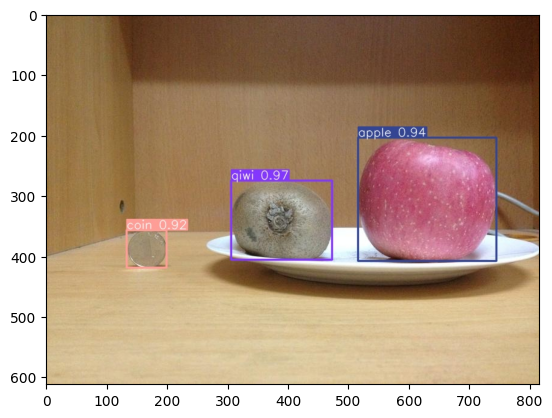

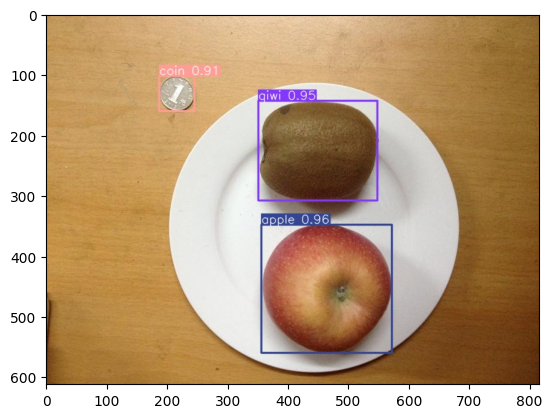

In [ ]:
display_img(pairs[55][0])
display_img(pairs[55][1])

### get bbox/cls lists

In [ ]:
# Example usage
print(extract_info_from_path(pairs[50][0]))
# Example usage
print(get_prediction_info(pairs[50][0],path_to_csv))

mango004S(3)
("['mango', 'coin']", "tensor([[425.0831, 312.5646, 580.6721, 391.5595,   0.9382,   4.0000],\n        [100.9915, 354.1611, 167.8828, 417.4966,   0.9113,   1.0000]], device='cuda:0')")


In [ ]:
# Example usage
cls,bbox = get_prediction_info(pairs[50][0],path_to_csv)
bbox_list = get_bbox_list(bbox)
print(bbox_list)

['[425.0831, 312.5646, 580.6721, 391.5595,   0.9382,   4.0000]', '[100.9915, 354.1611, 167.8828, 417.4966,   0.9113,   1.0000]']


In [ ]:
print(pairs[15][0],"\n",get_cls(pairs[15][0],path_to_csv),"\n",get_bbox(pairs[15][0],path_to_csv),"\n")
print(pairs[58][0],"\n",get_cls(pairs[58][0],path_to_csv),"\n",get_bbox(pairs[58][0],path_to_csv),"\n")
print(pairs[2][1],"\n",get_cls(pairs[2][1],path_to_csv),"\n",get_bbox(pairs[2][1],path_to_csv))

/content/drive/MyDrive/test_imgs_res/bun002S(1).JPG-YOLOv8-result.JPG 
 ['bun', 'coin'] 
 [[430.0007, 237.4076, 221.03900000000004, 142.9348], [102.2675, 320.678, 69.00670000000001, 65.3673]] 

/content/drive/MyDrive/test_imgs_res/mix010S(6).JPG-YOLOv8-result.JPG 
 ['tomato', 'lemon', 'coin'] 
 [[552.5814, 262.4084, 196.79779999999994, 132.21130000000005], [325.7307, 267.9569, 128.52639999999997, 121.82599999999996], [132.344, 349.5426, 61.42529999999999, 59.043499999999995]] 

/content/drive/MyDrive/test_imgs_res/apple016T(12).JPG-YOLOv8-result.JPG 
 ['apple', 'coin'] 
 [[414.5934, 197.0745, 232.98540000000003, 227.2378], [145.9162, 184.1489, 61.473299999999995, 61.91159999999999]]


In [ ]:
path_to_img = pairs[0][0]
bbox = get_bbox(path_to_img,path_to_csv)
cls = get_cls(path_to_img,path_to_csv)

print(f"The bbox of the object is: {bbox[1]}")
print(f"The bbox of the coin is: {bbox[0]}")
print(f"The class of the object is: {cls[-1]}")#looks like needs to be changed?
print(f"The class of the object is: {cls[0]}")

The bbox of the object is: [126.2341, 354.9417, 76.88430000000001, 73.66159999999996]
The bbox of the coin is: [431.7757, 173.4232, 236.7987, 227.72949999999997]
The class of the object is: coin
The class of the object is: apple


### find edge cases

In [ ]:
for i in set(top_and_side_cls_is_different(path_to_csv) +
             top_and_side_num_of_objs_not_equal(path_to_csv)):
             display_img(pairs[i][0])
             display_img(pairs[i][1])

We can see that in yolo outputs all side and top images has the same class for all objects in all images

### calc volume

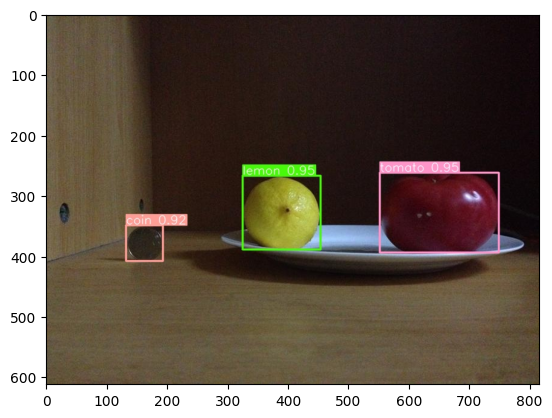

0.18909125014276382
[['lemon', [552.5814, 262.4084, 196.79779999999994, 132.21130000000005], [377.4326, 369.7114, 159.04880000000003, 142.98180000000002]], ['tomato', [325.7307, 267.9569, 128.52639999999997, 121.82599999999996], [392.4181, 60.7496, 193.32770000000005, 199.4545]], ['coin', [132.344, 349.5426, 61.42529999999999, 59.043499999999995], [134.777, 155.2034, 59.93060000000003, 58.384900000000016]]]
['coin', [132.344, 349.5426, 61.42529999999999, 59.043499999999995], [134.777, 155.2034, 59.93060000000003, 58.384900000000016]]
['tomato', [325.7307, 267.9569, 128.52639999999997, 121.82599999999996], [392.4181, 60.7496, 193.32770000000005, 199.4545]]
['lemon', [552.5814, 262.4084, 196.79779999999994, 132.21130000000005], [377.4326, 369.7114, 159.04880000000003, 142.98180000000002]]


In [ ]:
pair = pairs[58]
display_img(pair[0])
coin_bbox = organize_cls_and_bboxes(pair)[0][1]
ratio = calc_ratio(coin_bbox)

tomato = organize_cls_and_bboxes(pair)[1]
coin = organize_cls_and_bboxes(pair)[2]
lemon = organize_cls_and_bboxes(pair)[0]

print(ratio)
print(organize_cls_and_bboxes(pair))
print(coin)
print(tomato)
print(lemon)

In [ ]:
coin_bbox = organize_cls_and_bboxes(pair)[0][1]
ratio_s = calc_ratio(coin_bbox)

coin_bbox = organize_cls_and_bboxes(pair)[0][2]
ratio_t = calc_ratio(coin_bbox)

print("tomato height:\t",get_height(tomato[1],ratio_s),"mm")
print("lemon height:\t",get_height(lemon[1],ratio_s),"mm")
print("tomato radius:\t",get_radius(tomato[2],ratio_t),"mm")
print("lemon radius:\t",get_radius(lemon[2],ratio_t),"mm")

tomato_volume = get_volume(tomato[1],tomato[2],ratio_s,ratio_t,tomato[0])
lemon_volume = get_volume(lemon[1],lemon[2],ratio_s,ratio_t,lemon[0])

print("tomato volume:\t",tomato_volume, "mm^3")
print("lemon volume:\t",lemon_volume, "mm^3")

tomato height:	 23.036230639892338 mm
lemon height:	 25.0 mm
tomato radius:	 17.4370531773974 mm
lemon radius:	 12.5 mm
tomato volume:	 12.225201058390596 mm^3
lemon volume:	 4.393117392157165 mm^3


In [ ]:
get_volume_from_for_all_objs_in_plate(pair)

[['lemon', 64.52283881045653], ['tomato', 164.1772326196282]]

In [ ]:
print(get_weight(pair))
print(get_weight(pairs[10]))
print(get_weight(pairs[55]))
print(get_weight(pairs[70]))

[['lemon', 61.94192525803827], ['tomato', 160.89368796723562]]
[['bread', 20.254710856269956]]
[['apple', 168.1780398740248], ['qiwi', 174.81691115879065]]
[['peach', 74.75614091340313]]


### increase weight estimation accuracy

In [ ]:
ball_obj_example = pairs[4]
box_obj_example = pairs[14]
cylinder_obj_example = pairs[54]

print(pairs[0])
print(pairs[10])
print(pairs[50])

print("predict apple volume\t",get_volume_from_for_all_objs_in_plate(ball_obj_example)[0][1],"mm^3")
print("predict bread volume\t",get_volume_from_for_all_objs_in_plate(box_obj_example)[0][1],"mm^3")
print("predict mango volume\t",get_volume_from_for_all_objs_in_plate(cylinder_obj_example)[0][1],"mm^3")

print("real apple volume\t",get_real_v(pairs[4][0])[1],"mm^3")
print("real bread volume\t",get_real_v(pairs[14][0])[1],"mm^3")
print("real mango volume\t",get_real_v(pairs[54][0])[1],"mm^3")

('/content/drive/MyDrive/test_imgs_res/apple010S(1).JPG-YOLOv8-result.JPG', '/content/drive/MyDrive/test_imgs_res/apple010T(1).JPG-YOLOv8-result.JPG')
('/content/drive/MyDrive/test_imgs_res/bread001S(4).JPG-YOLOv8-result.JPG', '/content/drive/MyDrive/test_imgs_res/bread001T(4).JPG-YOLOv8-result.JPG')
('/content/drive/MyDrive/test_imgs_res/mango004S(3).JPG-YOLOv8-result.JPG', '/content/drive/MyDrive/test_imgs_res/mango004T(3).JPG-YOLOv8-result.JPG')
predict apple volume	 234.4401653218337 mm^3
predict bread volume	 84.35687138607082 mm^3
predict mango volume	 146.09994280741492 mm^3
real apple volume	 290 mm^3
real bread volume	 170 mm^3
real mango volume	 90 mm^3


In [ ]:
def get_volume(bbox_s,bbox_t,ratio_s,ratio_t,label):
  if objects[label][0] == "ball":
    return get_radius(bbox_t,ratio_t)**3 * math.pi * (4/3) * ball_volume_constant
  if objects[label][0] == "cylinder":
    return get_height(bbox_s,ratio_s) * get_circle_area(bbox_t,ratio_t) * cylinder_volume_constant
  if objects[label][0] == "box":
    return get_box_area(bbox_t,ratio_t) * get_height(bbox_s,ratio_s) * box_volume_constant
  if objects[label][0] == "ellipsoid":
    return 0

### accuracy test

In [ ]:
check_accuracy()
check_accuracy()

-------images-------
/content/drive/MyDrive/test_imgs_res/fired_dough_twist001S(5).JPG-YOLOv8-result.JPG
/content/drive/MyDrive/test_imgs_res/fired_dough_twist001T(5).JPG-YOLOv8-result.JPG 

-------predict-------
fired_dough_twist predict volume is 199.29112173230746 mm^3
fired_dough_twist predict weight is 125.5534066913537 g

-------real-------:
fired_dough_twist real volume is 60 mm^3
fired_dough_twist real weight is 37.8 g

-------error-------
volume error is 232.15186955384576 %
weight error is 232.1518695538458 %

-------images-------
/content/drive/MyDrive/test_imgs_res/mango009S(8).JPG-YOLOv8-result.JPG
/content/drive/MyDrive/test_imgs_res/mango009T(8).JPG-YOLOv8-result.JPG 

-------predict-------
mango predict volume is 56.94426980383224 mm^3
mango predict weight is 52.38872821952567 g

-------real-------:
mango real volume is 80 mm^3
mango real weight is 86.2 g

-------error-------
volume error is 28.819662745209694 %
weight error is 39.224213202406425 %



we can see that the accuracy is not bad, so we will keep the volume constant as before

In [ ]:
get_accuracy_in_all_dataset()

{'apple': 24.789456535913015,
 'banana': 96.53839104002255,
 'bread': 34.03580934870116,
 'bun': 56.38923051667314,
 'doughnut': 33.18094078180404,
 'egg': 26.552814158348998,
 'fired_dough_twist': 149.22698539220494,
 'grape': 34.13183282261242,
 'lemon': 21.906607050803707,
 'litchi': 26.521538886786793,
 'mango': 18.305544347432114,
 'mix': 31.299508664924513,
 'mooncake': 27.856585112166716,
 'orange': 18.66600529203023,
 'peach': 25.32010554507991,
 'pear': 34.113388735471275,
 'plum': 28.535473318407632,
 'qiwi': 18.09204318115021,
 'sachima': 73.54258903467593,
 'tomato': 7.327299386286792,
 'error of the data test': 39.3166074575748}

In [ ]:
error_summary()

Highest error: fired_dough_twist
Value: 149.22698539220494 %

Lowest error: tomato
Value: 7.327299386286792 %

Mean error:
Value : 39.3166074575748 %


##8.3. Interim Summary
The food weight prediction exhibited imprecision due to its reliance on bounding boxes rather than more accurate segmentation using masks. Bounding boxes provide a rectangular outline around the detected object, but they may not capture the irregular shapes of food items accurately. The use of masks or precise segmentation would may help us increase our estimation accuracy.

so now we move to our final stage, and use the model "SAM" - Segment Anything Model.
